<a href="https://colab.research.google.com/github/zzaeyun/ESAA22-2/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_201to211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **결정 트리 실습 - 사용자 행동 인식 데이터 세트**


---
- 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러 가지 피처를 수집한 데이터
- 피처 세트를 이용하여 어떠한 동작인지 예측
- train, test 피처 데이터 세트와 클래스 값 데이터 세트 
- 피처는 561개


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df=pd.read_csv('/features.txt', sep='\s+',
                            header=None, names=['column_index', 'columns_name'])

feature_name=feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:',feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


- 피처명을 살펴보면 인체의 움직임과 관련된 속성의 평균/표준편차가 X,Y,Z축 값으로 돼 있음


---


- 중복된 피처명을 가지고 있음
- 중복된 피처명이 얼마나 있는지 확인하기

In [6]:
feature_dup_df=feature_name_df.groupby('columns_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


column_index
columns_name                              
fBodyAcc-bandsEnergy()-1,16              3
fBodyAcc-bandsEnergy()-1,24              3
fBodyAcc-bandsEnergy()-1,8               3
fBodyAcc-bandsEnergy()-17,24             3
fBodyAcc-bandsEnergy()-17,32             3

In [7]:
import pandas as pd


def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test=get_human_dataset()

학습용 피처 데이터 세트 간략히 살펴보기

In [9]:
print('## 학습 피처 데이터셋 info( )')
print(X_train.info())

## 학습 피처 데이터셋 info( )
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


- 학습 데이터 세트는 7352개의 레코드로 561개의 피처를 가지고 있음
- 피처가 전부 float 형의 숫자 형이므로 인코딩 수행 X
- 많은 칼럼 대부분이 움직임 위치와 관련된 속성
- 레이블 값은 1, 2, 3, 4, 5, 6의 6개 값

In [10]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


DecisionTreeClassifier를 이용해 동작 예측 분류 수행

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

#DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


약 85.46%의 정확도


---

트리 깊이 Tree Depth가 예측 정확도에 주는 영향 살펴보기
- max_depth를 6, 8, 10, 12, 20, 24로 계속 늘리면서 예측 성능 측정

In [16]:
from sklearn.model_selection import GridSearchCV

params={
    'max_depth': [6,8,10,12,16,20,24]
}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCH 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCH 최적 하이퍼 파라미터: {'max_depth': 16}


max_depth가 8일 때 5개의 폴드 세트의 최고 평균 정확도 결과가 약 85.26%

GridSearchCV 객체의 cv_results_ 속성을 통해 max_depth 값에 딸느 예측 성능 변화 살펴보기

In [17]:
cv_results_df=pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

param_max_depth  mean_test_score
0               6         0.850791
1               8         0.851069
2              10         0.851209
3              12         0.844135
4              16         0.851344
5              20         0.850800
6              24         0.849440

- mean_test_score는 5개 CV 세트에서 검증용 데이터 세트의 정확도 평균 수치
- mead_test_score는 max_depth가 8일 때 0.852로 정확도가 정점이고, 이를 넘어가면서 정확도가 계속 떨어짐
- 결정트리는 더 완벽한 규칙을 학습 데이터 세트에 적용하기 위해 노드를 지속적으로 분할하면서 깊이가 깊어지고 더 복잠 
- 이는 검증 데이터 세트에서는 오히려 과적합으로 인한 성능 저하 유발

In [18]:
max_depths=[6,8,10,12,16,20,24]

for depth in max_depths:
  dt_clf= DecisionTreeClassifier(max_depth=depth, random_state=156)
  dt_clf.fit(X_train, y_train)
  pred=dt_clf.predict(X_test)
  accuracy=accuracy_score(y_test, pred)
  print('max_depth ={0} 정확도: {1:.4f}'.format(depth,accuracy))

max_depth =6 정확도: 0.8558
max_depth =8 정확도: 0.8707
max_depth =10 정확도: 0.8673
max_depth =12 정확도: 0.8646
max_depth =16 정확도: 0.8575
max_depth =20 정확도: 0.8548
max_depth =24 정확도: 0.8548


max_depth가 8일 경우 약 87.07%로 가장 높은 정확도


---

max_depth와 min_samples_split을 같이 변경하면서 정확도 성능 튜닝

In [24]:
params={
    'max_depth': [8,12,16,20],
    'min_samples_split':[16,24]
}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


max_depth가 8, min_samples_split이 16일 때 가장 최고의 정확도로 약 85.5%


---

별도 분리된 테스트 데이터 세트에 해당 하이퍼 파라미터 적용
- GridSearchCV 객체인 grid_cv의 속성인 best_estimator_는 최적의 파라미터인 max_depth 8, min_samples_split 16으로 학습이 완료된 Estimator 객체
- 그러므로 별도의 fitting이 필요 없음

In [25]:
best_df_clf=grid_cv.best_estimator_
pred1=best_df_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


feature_importances_ 속성을 이용하여 각 피처의 중요도를 알아보고 중요도가 높은 순으로 막대 그래프로 표현

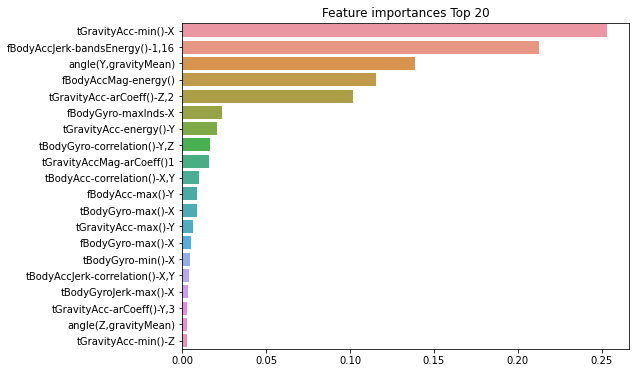

In [26]:
import seaborn as sns

ftr_importances_values=best_df_clf.feature_importances_

ftr_importances=pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()